## Follow the comment prompts to train a neural network

In [1]:
# very common imports
from math import floor
import numpy as np
from numpy.dtypes import StringDType
import pandas as pd
import matplotlib.pyplot as plt

# common torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.transforms import v2

# common sklearn imports 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

In [2]:
# we will not have a gpu accessible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not torch.cuda.is_available():
    print("CUDA is NOT available to Pytorch")
print(device)

CUDA is NOT available to Pytorch
cpu


In [7]:
# these parameters come from an imagenet study
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
transform_pipeline = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=means, std=stds)
])

In [42]:
# Create some data with the `simulate-exercise.ipynb` file
# Start small, and `ls -lh` to check how big the data is
# Modify the file names below accordingly 

# load the data
target_color = np.loadtxt('../data/target_color_small.txt', dtype=StringDType)
target_shape = np.loadtxt('../data/target_shape_small.txt', dtype=StringDType)
images = np.load('../data/images_small.npy')
images = torch.tensor(images).permute(0,3,1,2)

In [43]:
# label encode the targets
# so that the target is numeric

# Choose to model target_color or target_shape
# color is much easier than shape!
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

target = target_color
encoder = LabelEncoder()
encoder.fit(target)
target_encoded = encoder.transform(target)

In [44]:
# perform the train test split
# so that we evaluate the model
# on held out data
# use this function
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(
    images, target_encoded, test_size = 0.2, random_state=100395
)

# convert data to torch tensors
X_train = transform_pipeline(X_train)
X_test = transform_pipeline(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [45]:
# set up the data loader
# which is so we update the model
# in batches

# Experiment with different batch sizes
# You may require larger batch sizes than in Exercise 1

batch_size = 2 ** 7

# TO DO
# Define the dataset loader as train_loader and test_loader
# https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [20]:
# build a model class
# https://docs.pytorch.org/docs/stable/nn.html

# first, build a model without pooling layers
# second, add pooling layers
# third, add normalization and dropout layers
# optional, play with activation functions

# define the cnn math for the size of the next layer
# if building complicated models

def calculate_after_conv(height, kernel_size, stride, padding,):
    return floor((height + 2 * padding - kernel_size) / stride) + 1


# first, for the shape classifier
class MyCNN(nn.Module):
    '''Custom CNN to classify the shape or color of an object in an image'''

    def __init__(self,
                    num_classes,
                    height: int = 224,
                    width: int = 224,
                    num_input_channels = 3,
                    num_cnn_channels = 32,
                    num_cnn_layers = 0,
                    hidden_dim: int = 16,
                    num_layers: int = 0,
                    linear_activation = nn.ReLU,
                    kernel_size: int = 3,
                    stride: int = 1,
                    padding: int = 1,
                    pooling: int = 2,
                    dropout: float = 0.2,
                ):
        '''Initialize the model

        Parameters
        ----------
        num_classes : int
            Number of prediction classes,
            which is the output dimension
        width : int
            Dimensions of image
        height : int
            Dimensions of image
        num_input_channels : int
            Number of channels in input (3 for RGB color)
        num_cnn_channels : int
            Number of channels for all Conv2d() layers
        num_cnn_layers : int
            Number of Conv2d() layers on on top of
            an initial layer and an average pooling final layer
        hidden_dim : int
            Number of hidden units in Linear() layer
        num_layers : int
            Number of Linear() layers on top of an
            initial layer and a final layer
        linear_activation :
            Activation layer like nn.ReLU
        kernel_size : int
        stride : int
        padding : int
        pooling : int
        dropout : float
            The probability of dropout 
        '''

        # must have this
        # inherits the internal attributes 
        # and methods of nn.Module
        # which is a lot of machinery
        # that we do not want to write
        # from scratch
        super(MyCNN, self).__init__()

        self.num_classes_ = num_classes
        self.height_ = height
        self.width_ = width

        # convolutional layers

        cnn_layers = []

        cnn_layers.append(
            nn.Conv2d(
                num_input_channels,
                num_cnn_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                )
        )
        cnn_layers.append(nn.BatchNorm2d(num_cnn_channels))
        cnn_layers.append(
            nn.MaxPool2d(pooling,)
        )

        for _ in range(num_cnn_layers):
            cnn_layers.append(
            nn.Conv2d(
                num_cnn_channels,
                num_cnn_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                )
            )
            cnn_layers.append(nn.BatchNorm2d(num_cnn_channels))
            cnn_layers.append(
                nn.MaxPool2d(pooling,)
            )

        cnn_layers.append(
            nn.Conv2d(
                num_cnn_channels,
                num_cnn_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                )
        )
        cnn_layers.append(nn.BatchNorm2d(num_cnn_channels))
        cnn_layers.append(
            nn.AvgPool2d(pooling,)
        )

        self.conv_block = nn.Sequential(*cnn_layers)

        # update the dimension
        height = calculate_after_conv(height, kernel_size, stride, padding)
        height = calculate_after_conv(height, pooling, pooling, 0)
        width = calculate_after_conv(width, kernel_size, stride, padding)
        width = calculate_after_conv(width, pooling, pooling, 0)
        for _ in range(num_cnn_layers):
            height = calculate_after_conv(height, kernel_size, stride, padding)
            height = calculate_after_conv(height, pooling, pooling, 0)
            width = calculate_after_conv(width, kernel_size, stride, padding)
            width = calculate_after_conv(width, pooling, pooling, 0)
        height = calculate_after_conv(height, kernel_size, stride, padding)
        height = calculate_after_conv(height, pooling, pooling, 0)
        width = calculate_after_conv(width, kernel_size, stride, padding)
        width = calculate_after_conv(width, pooling, pooling, 0)

        # linear layers
        linear_layers = []

        linear_layers.append(
            nn.Linear(
                width * height * num_cnn_channels,
                hidden_dim,
            )
        )
        linear_layers.append(nn.BatchNorm1d(hidden_dim))
        linear_layers.append(linear_activation())
        linear_layers.append(nn.Dropout(dropout))

        for _ in range(num_layers):
            linear_layers.append(
                nn.Linear(hidden_dim, hidden_dim)
            )        
            linear_layers.append(nn.BatchNorm1d(hidden_dim))
            linear_layers.append(linear_activation())
            linear_layers.append(nn.Dropout(dropout))

        self.linear_block = nn.Sequential(*linear_layers)

        # final layer
        self.output_block = nn.Linear(hidden_dim,
            num_classes,
        )

    def forward(self, x):
        '''Where we specify the order of neural network layers

        Parameters
        ----------
        x : torch.Tensor
            Tensor of shape (batch_size, num_input_channels, height, width)
        
        Returns
        -------
        torch.Tensor
            Output is (batch_size, num_classes)
        '''

        # cnn layers
        x = self.conv_block(x)
        
        # flatten
        x = x.view(x.size(0), -1)

        # linear layers
        x = self.linear_block(x)

        # linear layer to output
        x = self.output_block(x)

        return x

In [26]:
# choose model architecture
num_cnn_channels = 2 ** 5
num_cnn_layers = 1
num_layers = 1
hidden_dim = 2 ** 4
kernel_size = 3
stride = 1
padding = 1
pooling = 2
dropout = 0.2
linear_activation = nn.ReLU

In [46]:
# initialize the model
channels, width, height = images[0].shape
num_classes = len(y_train.unique())
model = MyCNN(
    num_classes, # number of classes
    width,
    height,
    channels,
    num_cnn_channels,
    num_cnn_layers,
    hidden_dim,
    num_layers,
    linear_activation,
    kernel_size,
    stride,
    padding,
    pooling,
    dropout,
)

model.to(device) # relevant if using gpus

# define the loss function
# what is a good loss function for multiclass classification
criterion = nn.CrossEntropyLoss()

# choose an optimizer
# https://docs.pytorch.org/docs/stable/optim.html

optimizer = optim.Adam(
    model.parameters(), # would not be available if not for super()
    lr=1e-4, # learning rate
)

model

MyCNN(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=25088, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): L

In [48]:
# check how big the model is
num_parameters = [p.numel() for p in model.parameters()]
print(sum(num_parameters))

421480


In [49]:
# write the training loop

num_epochs = 30

train_losses = []
test_losses = []

for epoch in range(num_epochs):

    model.train() # very important
    running_loss = 0.
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        
        # put on the gpu or cpu device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward pass
        pred = model(inputs.float())

        # compute the loss
        loss = criterion(pred, labels)

        # backward pass
        # to change parameters
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # to track progress relative to training
    model.eval() # very important
    running_loss = 0.
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs.float())
            loss = criterion(pred, labels)
            running_loss += loss.item()

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss {test_loss:.4f}")

Epoch 1/30, Train Loss: 2.0824, Test Loss 2.0685
Epoch 2/30, Train Loss: 1.9058, Test Loss 2.0441
Epoch 3/30, Train Loss: 1.8564, Test Loss 2.0129
Epoch 4/30, Train Loss: 1.8089, Test Loss 1.9867
Epoch 5/30, Train Loss: 1.7688, Test Loss 1.9629
Epoch 6/30, Train Loss: 1.7354, Test Loss 1.9409
Epoch 7/30, Train Loss: 1.7294, Test Loss 1.9239
Epoch 8/30, Train Loss: 1.7053, Test Loss 1.9096
Epoch 9/30, Train Loss: 1.6894, Test Loss 1.9032
Epoch 10/30, Train Loss: 1.6524, Test Loss 1.8963
Epoch 11/30, Train Loss: 1.6528, Test Loss 1.8909
Epoch 12/30, Train Loss: 1.6242, Test Loss 1.8891
Epoch 13/30, Train Loss: 1.5982, Test Loss 1.8864
Epoch 14/30, Train Loss: 1.6149, Test Loss 1.8828
Epoch 15/30, Train Loss: 1.5910, Test Loss 1.8795
Epoch 16/30, Train Loss: 1.5881, Test Loss 1.8719
Epoch 17/30, Train Loss: 1.5619, Test Loss 1.8672
Epoch 18/30, Train Loss: 1.5749, Test Loss 1.8657
Epoch 19/30, Train Loss: 1.5638, Test Loss 1.8670
Epoch 20/30, Train Loss: 1.5521, Test Loss 1.8693
Epoch 21/

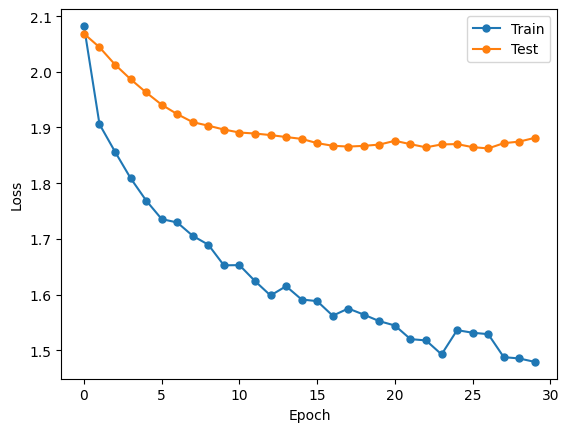

In [55]:
# You want to see train loss and the test loss decrease
# Technically, this is the validation loss
plt.plot(train_losses, '-o', color='tab:blue', label='Train', markersize=5)
plt.plot(test_losses, '-o',  color='tab:orange', label='Test', markersize=5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [56]:
# Print the max gradient of the first layer
# If this is 0 or None, then the gradients aren't flowing
# You have an issue
# Often, this is from dimension mismatching
print(next(model.parameters()).grad.abs().max()) 

tensor(0.0161)


In [57]:
# evaluate all of the test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test.float().contiguous()).argmax(dim=1)

In [58]:
# compute the confusion matrix
confmat = confusion_matrix(
    y_test,
    y_pred,
)

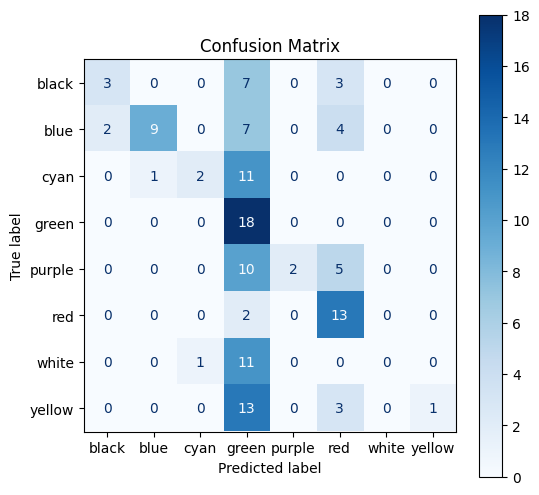

In [59]:
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=encoder.classes_)
disp.plot(ax=ax, cmap='Blues')
ax.set_title("Confusion Matrix")
plt.show()

In [62]:
# Calculate per-class precision and recall
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)

# Create a DataFrame for better visualization
pr_table = pd.DataFrame({
    'Class': encoder.classes_,
    'Precision': precision_per_class,
    'Recall': recall_per_class
})

pr_table

/home/sdtemple/sandboxes/zootopia3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Class,Precision,Recall
0,black,0.600000,0.230769
1,blue,0.900000,0.409091
2,cyan,0.666667,0.142857
3,green,0.227848,1.000000
4,purple,1.000000,0.117647
5,red,0.464286,0.866667
6,white,0.000000,0.000000
7,yellow,1.000000,0.058824


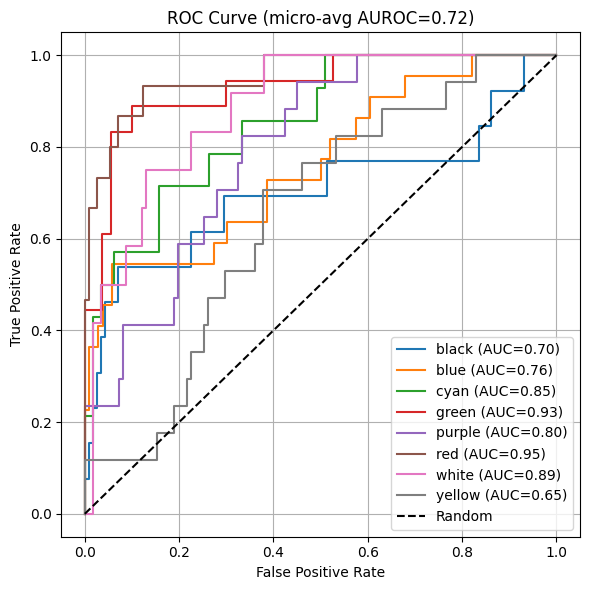

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

n_classes = len(encoder.classes_)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
auroc_micro = roc_auc_score(y_true_bin, y_score, average="micro")

plt.figure(figsize=(6, 6))
for idx, cls in enumerate(encoder.classes_):
    fpr, tpr, _ = roc_curve(y_true == idx, y_score[:, idx])
    auroc = roc_auc_score(y_true == idx, y_score[:, idx])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auroc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (micro-avg AUROC={auroc_micro:.2f})")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Now, modularize the MyCNN class into `src/zootopia3/models/models.py`